In [18]:
# You can import *ANYTHING* you want here.
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBRegressor
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, BaggingRegressor, RandomForestRegressor
from sklearn.metrics import mean_absolute_percentage_error # Requires sklearn 0.24 (December 2020), update with conda/pip if needed.
from sklearn.model_selection import GridSearchCV, train_test_split
from collections import OrderedDict

import pandas as pd

# Tree methods

In this assignment we'll study tree methods and their capabilities as interpolators and extrapolators, and the importance of understanding your data. We will use a dataset of energy consumption of home appliances for houses in Chievres, Belgium. The data has the following variables:

- date time year-month-day hour:minute:second
- Appliances, energy use in Wh (**Target variable**)energy_extrapolation
- lights, energy use of light fixtures in the house in Wh
- T1, Temperature in kitchen area, in Celsius
- RH_1, Humidity in kitchen area, in %
- T2, Temperature in living room area, in Celsius
- RH_2, Humidity in living room area, in %
- T3, Temperature in laundry room area
- RH_3, Humidity in laundry room area, in %
- T4, Temperature in office room, in Celsius
- RH_4, Humidity in office room, in %
- T5, Temperature in bathroom, in Celsius
- RH_5, Humidity in bathroom, in %
- T6, Temperature outside the building (north side), in Celsius
- RH_6, Humidity outside the building (north side), in %
- T7, Temperature in ironing room , in Celsius
- RH_7, Humidity in ironing room, in %
- T8, Temperature in teenager room 2, in Celsius
- RH_8, Humidity in teenager room 2, in %
- T9, Temperature in parents room, in Celsius
- RH_9, Humidity in parents room, in %
- To, Temperature outside (from Chievres weather station), in Celsius
- Pressure (from Chievres weather station), in mm Hg
- RH_out, Humidity outside (from Chievres weather station), in %
- Wind speed (from Chievres weather station), in m/s
- Visibility (from Chievres weather station), in km
- Tdewpoint (from Chievres weather station), in C degrees

You are given two datasets: energy_appliances_standard.csv and energy_appliances_extrapolation.csv. The first dataset has typical consumption patterns, while the second one has the top 10% highest consumptions and will be used to test the extrapolating capacities of our models.


## Task 1: Random Forests (35/100)

Random Forests are excellent predictors. Usually we only need to tune one parameter: the number of trees in the model. However, how many trees are enough? Follow these steps:

1. Load the training dataset (energy_appliances_standard.csv) and show the descriptive statistics of the variables. (3 pts)

2. Create a train / test partition of the data using 30% of the data for the test set and a ```random_state``` value of 20201107(2 pts).

3. Follow [this example](https://scikit-learn.org/stable/auto_examples/ensemble/plot_ensemble_oob.html) and train a [Random Forest Regressor](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html) using ```Appliances``` as the target variable. Test between 50 and 250 trees, plotting the Out-of-Bag (OOB) error after every iteration. Be patient as training can take a while. Written answer: What is the optimal number of trees for your model and why do you think this? (15 pts)

4. Train your final random forest with the number of trees you selected in part 3. Apply this model over your test set and over the extrapolating dataset (from the file ```energy_appliances_extrapolation.csv```), calculating the mean absolute percentual error for each dataset.  Show in a scatterplot the predicted value vs the real value of the target variable for both the test set and the extrapolation set (in the same plot), differentiating both by using different colors for the points. Written answer: How does the random forest model perform on predicting Appliance energy usage in the extrapolation data set? If it performs poorly, why? If it performs well, why? *Hint: look at the scatterplot*. (15 points)

In [19]:
# Data load
training_DS = pd.read_csv("energy_appliances_standard.csv")
training_DS.describe()

,Appliances,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,RH_4,...,T8,RH_8,T9,RH_9,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint
count,17735.000000,17735.000000,17735.000000,17735.000000,17735.000000,17735.000000,17735.000000,17735.000000,17735.000000,17735.000000,...,17735.000000,17735.000000,17735.000000,17735.000000,17735.000000,17735.000000,17735.000000,17735.000000,17735.000000,17735.000000
mean,68.121229,3.445729,21.688855,40.150264,20.293891,40.469997,22.230926,39.160423,20.860319,38.983631,...,22.050534,43.016242,19.505556,41.552215,7.314032,755.566425,80.249079,3.969812,38.305214,3.762879
std,30.182146,7.552424,1.604312,3.930099,2.171999,4.063088,1.969945,3.219280,2.047586,4.320711,...,1.961083,5.202160,2.010550,4.161873,5.291010,7.339842,14.768037,2.447164,11.957900,4.187098
min,10.000000,0.000000,16.790000,27.023333,16.100000,20.463333,17.200000,28.766667,15.100000,27.660000,...,16.306667,29.600000,14.890000,29.166667,-5.000000,729.366667,24.000000,0.000000,1.000000,-6.600000
25%,50.000000,0.000000,20.760000,37.260000,18.790000,37.930000,20.790000,36.826667,19.566667,35.500000,...,20.828889,39.200000,18.066667,38.530000,3.500000,751.000000,71.333333,2.000000,29.000000,0.933333
50%,60.000000,0.000000,21.600000,39.533333,19.926667,40.545000,22.100000,38.466667,20.666667,38.363333,...,22.166667,42.440000,19.390000,40.863333,6.850000,756.100000,84.333333,3.500000,40.000000,3.433333
75%,80.000000,0.000000,22.600000,42.863333,21.463333,43.326667,23.290000,41.530000,22.100000,42.066667,...,23.390000,46.590000,20.600000,44.290000,10.333333,760.950000,91.845238,5.333333,40.000000,6.550000
max,190.000000,50.000000,26.200000,59.633333,29.856667,56.026667,29.100000,49.656667,26.200000,51.000000,...,27.230000,58.780000,24.500000,53.326667,26.100000,772.283333,100.000000,14.000000,66.000000,15.500000


In [20]:
# Create train / test split
train, test = train_test_split(training_DS, test_size=0.3, random_state=20201107)

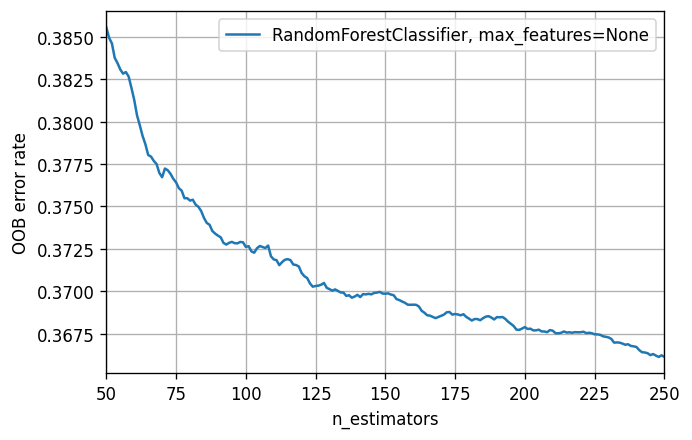

In [20]:
# Define random forest and iterate over the number of trees

X = train.iloc[:,1:]
y = train['Appliances']
###############
ensemble_clfs = [
    ("RandomForestRegressor, max_features=None",
        RandomForestRegressor(warm_start=True, max_features=None,
                               oob_score=True,
                               random_state=20201107))
]


# Map a classifier name to a list of (<n_estimators>, <error rate>) pairs.
error_rate = OrderedDict((label, []) for label, _ in ensemble_clfs)

# Range of `n_estimators` values to explore.
min_estimators = 50
max_estimators = 250

for label, clf in ensemble_clfs:
    for i in range(min_estimators, max_estimators + 1):
        clf.set_params(n_estimators=i)
        clf.fit(X, y)

        # Record the OOB error for each `n_estimators=i` setting.
        oob_error = 1 - clf.oob_score_
        error_rate[label].append((i, oob_error))

fig, ax = plt.subplots(dpi = 120)
# Generate the "OOB error rate" vs. "n_estimators" plot.
for label, clf_err in error_rate.items():
    xs, ys = zip(*clf_err)
    plt.plot(xs, ys, label=label)

plt.xlim(min_estimators, max_estimators)
plt.xlabel("n_estimators")
plt.ylabel("OOB error rate")
plt.legend(loc="upper right")
plt.grid()
plt.show()


**Written answer:** with (135-150) and (215-225) number of estimators we get a reasonably low error. 

In [21]:
# # Define random forest and iterate over the number of trees

# X = train.iloc[:,1:]
# y = train['Appliances']
# ###############

# rf_clf = RandomForestRegressor(warm_start=True, max_features=None,
#                                oob_score=True,
#                                random_state=20201107)

# # Map a classifier name to a list of (<n_estimators>, <error rate>) pairs.
# error_rate = []
# error_score = []
# # Range of `n_estimators` values to explore.
# min_estimators = 50
# max_estimators = 250

# # for label, clf in ensemble_clfs:
# for i in range(min_estimators, max_estimators + 1):
#     rf_clf.set_params(n_estimators=i)
#     rf_clf.fit(X, y)

#     # Record the OOB error for each `n_estimators=i` setting.
#     oob_error = 1 - rf_clf.oob_score_
#     error_score.append((i,rf_clf.oob_score_))
#     error_rate.append((i, oob_error))


In [22]:
# # Plot the OOB error per number of trees

# fig, ax = plt.subplots(dpi = 150)

# xs_scr = np.array(error_score)[:,0]
# ys_scr = np.array(error_score)[:,1]
# plt.plot(xs_scr, ys_scr, label='error_score', color='b')

# plt.xlim(min_estimators, max_estimators)
# plt.xlabel("n_estimators")
# plt.ylabel("OOB error")
# plt.legend(loc="upper right")
# plt.grid()
# plt.show()

In [23]:
# # error_rate
# fig, ax = plt.subplots(dpi = 120)
# # Generate the "OOB error rate" vs. "n_estimators" plot.
# xs = np.array(error_rate)[:,0]
# ys = np.array(error_rate)[:,1]
# plt.plot(xs, ys, label='error_rate', color='k')
# plt.xlim(min_estimators, max_estimators)
# plt.xlabel("n_estimators")
# plt.ylabel("OOB error rate")
# plt.legend(loc="upper right")
# plt.grid()
# plt.show()

In [33]:
### Final forest

rf_clf = RandomForestRegressor(warm_start=True, max_features=None, n_estimators=220,
                               oob_score=True,
                               random_state=20201107)
# rf_clf.set_params(criterion = 'mae')

X = train.iloc[:,1:]
y = train['Appliances']
rf_clf.fit(X, y)

ypred_test = rf_clf.predict(test.iloc[:,1:])


In [34]:
### Calculate error over test set
sys_error_test = mean_absolute_percentage_error(test['Appliances'], ypred_test)

print(f'the system calculated mape for test data set is :{error}')

# error_test = np.abs((ypred_test - test['Appliances'])/ypred_test.mean()).mean() * 100
# print(f'the mean absolute percentile error for test data set is :{error_test}')

the system calculated mape for test data set is :0.19295192214738988


In [35]:
# ### Load the second dataset

extpl_DS = pd.read_csv("energy_appliances_extrapolation.csv")

ypred_extpl = rf_clf.predict(extpl_DS.iloc[:,1:])

### Calculate the error over it

sys_error_extpl = mean_absolute_percentage_error(extpl_DS['Appliances'], ypred_extpl)
# error_extpl = np.abs((ypred_extpl - extpl_DS['Appliances'])/ypred_extpl.mean()).mean() * 100

In [36]:
# Print MAPE over the sets
print(f'the system calculated mean absolute percentile error forextrapolated data set is :{sys_error_extpl}')
# print(f'the mean absolute percentile error for extrapolated data set is :{error_extpl}')


the system calculated mean absolute percentile error forextrapolated data set is :0.6990452324266517


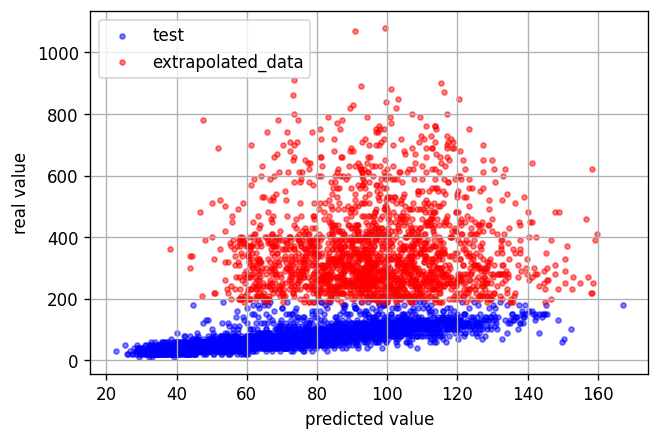

In [32]:
# Make the scatterplot
fig, ax = plt.subplots(dpi = 120)

plt.scatter(ypred_test,test['Appliances'] ,marker = '.',color = 'b',\
            alpha = 0.5, label = 'test')

plt.scatter(ypred_extpl, extpl_DS['Appliances'], marker = '.', color = 'r',\
            alpha = 0.5, label = 'extrapolated_data')

plt.xlabel("predicted value")
plt.ylabel("real value")
plt.legend(loc=2)
# plt.xrange()
plt.grid()
plt.show()

**Written answer:**  The predicted data for the extraplolation data set is not as good as the test data set, the extrapolation data has been taken from higher outliers that the model is not as good. Also we are getting way higher mean absolute percentage error for the exrapolation data.

## Task 2: XGBoosting model (40 pts)

Now we'll repeat the process for the XGB model, using an [```XGBRegressor``` object](https://xgboost.readthedocs.io/en/latest/python/python_api.html). The XGBoosting model is much more sensitive to parameter changes though as it allows to tune many different parameters. For this example:

1. Written answer: Why do we say we want to use a small learning rate? Why do we say the number of trees to use depends on each dataset/problem? Why do we want to use a small tree depth? (6 pts)

2. Selecting a 30% validation sample over the training set, tune your parameters using crossvalidation. Use the following ranges:
 - Learning rate: [0.01, 0.1, 0.2].
 - max_depth: 3 to 7.
 - Number of trees: [350, 400, 450, 500]

Leave the other parameters at the values we identified in the lab (`except for the objective parameter and those related to classification problems`) and use a seed of 20201107. Report the optimal values of your parameters. (20 pts)

3. Repeat part 4 of the previous task, but now for your XGB model trained over the optimal parameter combination and the complete training dataset. Plot the variable importance. Written answer: What are the most important variables? Can the XGB model extrapolate? How does it compare to a random forest? (14 pts)

**Written answer part 1 (2 pts each):**
learning rate controls when to stop adding more levels to a tree and cut it when we are not gaining much accuracy with going deeper. Smaller learning rate means continue leveling the tree even if it makes the efficiency a bit better. 
When we don't have many observations, having very larg number of trees might end up to their repeatition without adding new information.
We want smaller tree depth to make sure we are not overfitting. 

In [69]:
# Define the XGB model
XGB_Energy = XGBRegressor(max_depth=3,                 # Depth of each tree
                            learning_rate=0.1,            # How much to shrink error in each subsequent training. Trade-off with no. estimators.
                            n_estimators=100,             # How many trees to use, the more the better, but decrease learning rate if many used.
                            verbosity=1,                  # If to show more errors or not.
                            objective='reg:squarederror',  # Type of target variable.
                            booster='gbtree',             # What to boost. Trees in this case.
                            n_jobs=4,                     # Parallel jobs to run. Set your processor number.
                            gamma=0.001,                  # Minimum loss reduction required to make a further partition on a leaf node of the tree. (Controls growth!)
                            subsample=1,              # Subsample ratio. Can set lower than 1. If we want perfect boosting
                            colsample_bytree=1,           # Subsample ratio of columns when constructing each tree.
                            colsample_bylevel=1,          # Subsample ratio of columns when constructing each level. 0.33 is similar to random forest. sqrt(no.var)
                            colsample_bynode=1,           # Subsample ratio of columns when constructing each split.
                            reg_alpha=1,                  # Regularizer for first fit. alpha = 1, lambda = 0 is LASSO.
                            reg_lambda=0,                 # Regularizer for first fit.
                            scale_pos_weight=1,           # Balancing of positive and negative weights.
                            base_score=0.5,               # Global bias. Set to average of the target rate.
                            random_state=20201107,        # Seed
                            missing=None                  # How are nulls encoded?
                            )

In [70]:
# Define the parameter grid.
param_grid = dict({'learning_rate': [0.01, 0.1, 0.2],
                   'max_depth': [3, 4, 5, 6, 7],
                   'n_estimators': [350, 400, 450, 500]  
                  })

In [71]:
# Create reduced validation set.
val_train = train.sample(frac = 0.3, 
                         random_state = 20201107)

In [72]:
# Define the grid search object
GridXGB = GridSearchCV(XGB_Energy,
                       param_grid,
                       cv = 3,
                       n_jobs = 4,
                       refit = False,
                       verbose = 1
                        )

# Train grid search. This takes a while! Go grab a coffee.
GridXGB.fit(val_train.iloc[:,1:], val_train['Appliances'])

Fitting 3 folds for each of 60 candidates, totalling 180 fits


GridSearchCV(cv=3,
             estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                                    colsample_bylevel=1, colsample_bynode=1,
                                    colsample_bytree=1, gamma=0.001,
                                    gpu_id=None, importance_type='gain',
                                    interaction_constraints=None,
                                    learning_rate=0.1, max_delta_step=None,
                                    max_depth=3, min_child_weight=None,
                                    missing=None, monotone_constraints=None,
                                    n_estimators=100, n_jobs=4,
                                    num_parallel_tree=None,
                                    random_state=20201107, reg_alpha=1,
                                    reg_lambda=0, scale_pos_weight=1,
                                    subsample=1, tree_method=None,
                                    validate_parameters=None, verbos

In [74]:
# Show best params
GridXGB.best_params_

{'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 350}

In [75]:
#Creat XGB with optimal parameters
XGB_Energy = XGBRegressor(max_depth=GridXGB.best_params_.get('max_depth'),                 # Depth of each tree
                            learning_rate=GridXGB.best_params_.get('learning_rate'),            # How much to shrink error in each subsequent training. Trade-off with no. estimators.
                            n_estimators=GridXGB.best_params_.get('n_estimators'),             # How many trees to use, the more the better, but decrease learning rate if many used.
                            verbosity=1,                  # If to show more errors or not.
                            objective='reg:squarederror',  # Type of target variable.
                            booster='gbtree',             # What to boost. Trees in this case.
                            n_jobs=4,                     # Parallel jobs to run. Set your processor number.
                            gamma=0.001,                  # Minimum loss reduction required to make a further partition on a leaf node of the tree. (Controls growth!)
                            subsample=1,              # Subsample ratio. Can set lower than 1. If we want perfect boosting
                            colsample_bytree=1,           # Subsample ratio of columns when constructing each tree.
                            colsample_bylevel=1,          # Subsample ratio of columns when constructing each level. 0.33 is similar to random forest. sqrt(no.var)
                            colsample_bynode=1,           # Subsample ratio of columns when constructing each split.
                            reg_alpha=1,                  # Regularizer for first fit. alpha = 1, lambda = 0 is LASSO.
                            reg_lambda=0,                 # Regularizer for first fit.
                            scale_pos_weight=1,           # Balancing of positive and negative weights.
                            base_score=0.5,               # Global bias. Set to average of the target rate.
                            random_state=20201107,        # Seed
                            missing=None                  # How are nulls encoded?
                            )

In [76]:
# Train final XGB with optimal parameters
XGB_Energy.fit(train.iloc[:,1:], train['Appliances'])

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0.001, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.1, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=None, monotone_constraints='()',
             n_estimators=350, n_jobs=4, num_parallel_tree=1,
             random_state=20201107, reg_alpha=1, reg_lambda=0,
             scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=1)

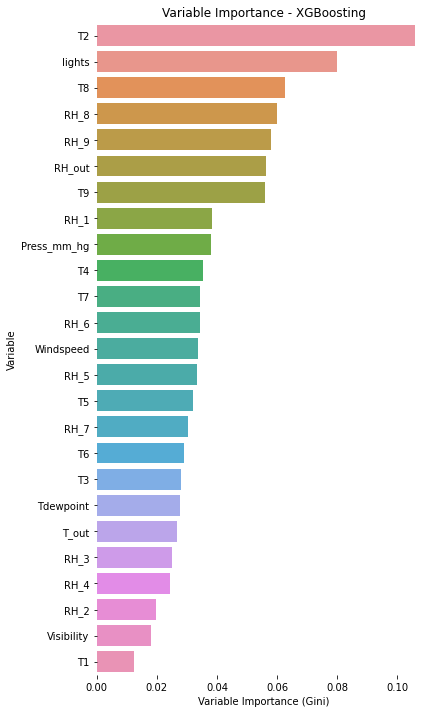

In [77]:
# Variable importance
importance = XGB_Energy.feature_importances_

indices = np.argsort(importance)[::-1]

f, ax = plt.subplots(figsize=(6, 12))
plt.title("Variable Importance - XGBoosting")
sns.set_color_codes("muted")
sns.barplot(y = [train.iloc[:,1:].columns[i] for i in indices],
            x = importance[indices])

ax.set(ylabel = 'Variable', xlabel = 'Variable Importance (Gini)')
sns.despine(left = True, bottom = True)

**Written answer:**
The three most important feature in the energy concumption are `living room temp` and `light fictures energy consumption` and `teenager'e room temperature` respectively.
The three least important features in the energy concumption are `the kintchen temperature`, `visibility` and `humidity in living room`.


This is perhaps the fundamental flaw inherent in all tree-based models. It doesn’t matter if you have a single decision tree, a random forest with 100 trees, or an XGBoost model with 1000 trees. Due to the method with which tree-based models partition the input space of any given problem, these algorithms are largely unable to extrapolate target values beyond the limits of the training data when making predictions. This is usually not a huge problem in classification tasks, but it is definitely a limitation when it comes to regression tasks that involve predicting a continuous output.

Text(0, 0.5, 'Real Energy concumption')

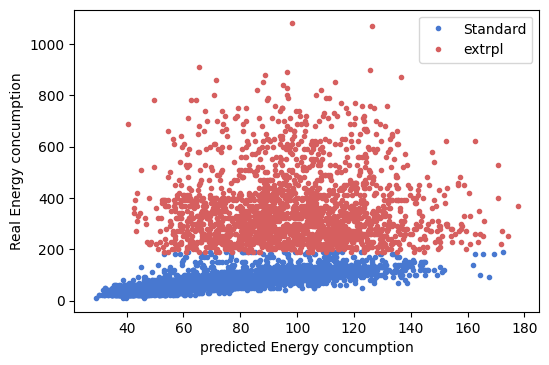

In [84]:
# Make scatterplot
# f = plt.subplots(figsize=(10,10))
f = plt.subplots(dpi = 100)

ypred = XGB_Energy.predict(test.iloc[:,1:])
plt.plot(ypred , test['Appliances'], '.b',label = 'Standard')


ypred_extpl = XGB_Energy.predict(extpl_DS.iloc[:,1:])
plt.plot(ypred_extpl , extpl_DS['Appliances'], '.r', label='extrpl')
plt.legend()
plt.xlabel('predicted Energy concumption')
plt.ylabel('Real Energy concumption')

**Written answer: **

## Task 3: Combined model (25 pts)

Now we will finally train a model on the combined data, by joining the extrapolation and the original dataset, and study the performance over the original test set, the new test set and the combined result. For this we will only use the Random Forest model. Use a seed of 20201107 for all functions that accept one.

1. Create a train / test split set over the extrapolation data, leaving approximately 30% of the data for testing purposes. Combine this train test with the original train set (let's call this the combined train set). (5 pts)
2. Train a Random Forest model over the **combined** train data. Discuss how many trees you used and why. (15 pts)
3. Plot the variable importance and compare it versus the XGB in task 1. Now that you more data, does the importance change? (5 pts)
3. Report the test set performance of your new model over the original test set, the test set you took over the extrapolation dataset and the combined test set. Plot the scatterplot of the both datasets as before in the same plot, differentiating the dataset by using colours. (10 pts)

Written answer: What happens now? What can you say about the new model?

In [50]:
# Create the new train and test set.
extpl_DS = pd.read_csv("energy_appliances_extrapolation.csv")
extpl_train, extpl_test = train_test_split(extpl_DS, test_size=0.3, random_state=20201107) 

combined_train = pd.concat([train, extpl_train], axis=0, copy=True)

In [51]:
# Obtain the new random forest (tune the trees)
RF_Energy = RandomForestRegressor(n_estimators = 100,
                                  max_depth = 10,
                                  min_samples_leaf = 10,
                                  criterion='mse',    # {"mse", "mae"}, default="mse"
                                  min_samples_split = 2,
                                  max_features='auto',
                                  bootstrap=True,
                                  oob_score=True,
                                  n_jobs =-1,
                                  verbose=1,
                                  warm_start = False,
                                  random_state=20201107
                                )

In [52]:
# Define the parameter grid.
param_grid = dict({'n_estimators': [300, 400, 500]  
                  })

# Define the grid search object
GridRF = GridSearchCV(RF_Energy,
                       param_grid,
                       cv = 3,
                       n_jobs = -1,
                       refit = False,
                       verbose = 1
                        )

In [53]:
# Train grid search. This takes a while! Go grab a coffee.
GridRF.fit(combined_train.iloc[:,1:], combined_train['Appliances'])

Fitting 3 folds for each of 3 candidates, totalling 9 fits


GridSearchCV(cv=3,
             estimator=RandomForestRegressor(max_depth=10, min_samples_leaf=10,
                                             n_jobs=-1, oob_score=True,
                                             random_state=20201107, verbose=1),
             n_jobs=-1, param_grid={'n_estimators': [300, 400, 500]},
             refit=False, verbose=1)

In [54]:
print(GridRF.best_params_)
RF_Energy = RandomForestRegressor(n_estimators=GridRF.best_params_.get('n_estimators'),
                                  max_depth=10,
                                  min_samples_leaf = 1,
                                  criterion='mse',
                                  min_samples_split = 2,
                                  max_features='auto',
                                  n_jobs =-1,
                                  verbose=1,
                                  warm_start = False,
                                  random_state=20201107
                                )

{'n_estimators': 400}


In [55]:
RF_Energy.fit(combined_train.iloc[:,1:], combined_train['Appliances'])

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    4.5s
[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:    9.2s finished


RandomForestRegressor(max_depth=10, n_estimators=400, n_jobs=-1,
                      random_state=20201107, verbose=1)

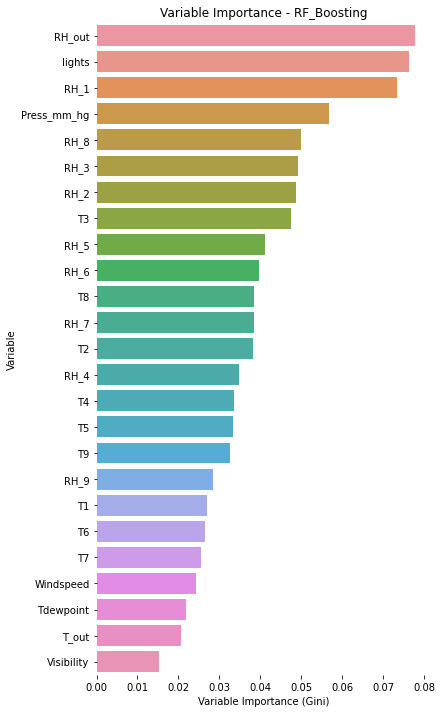

In [56]:
# Variable importance
importance = RF_Energy.feature_importances_

indices = np.argsort(importance)[::-1]

f, ax = plt.subplots(figsize=(6, 12))
plt.title("Variable Importance - RF_Boosting")
sns.set_color_codes("muted")
sns.barplot(y = [combined_train.iloc[:,1:].columns[i] for i in indices],
            x = importance[indices])

ax.set(ylabel = 'Variable', xlabel = 'Variable Importance (Gini)')
sns.despine(left = True, bottom = True)

**Written answer:** Gridsearch reports 400 as the best number of trees.
Unlike the XGB, the most important parameter is `RH_out` which is the outside humidity and the least important parametere is `visibility` whereas XGB result was the kitchen temperature. 

In [61]:
# Print MAPE over the test sets
pred_test = RF_Energy.predict(test.iloc[:,1:])
MAPE_test = mean_absolute_percentage_error(test['Appliances'], pred_test)
print(f'The MAPE value for original test data is : {MAPE_test}')

pred_test_extpl = RF_Energy.predict(extpl_test.iloc[:,1:])
MAPE_extpl = mean_absolute_percentage_error(extpl_test['Appliances'], pred_test_extpl)
print(f'The MAPE value for extrapolated test data is : {MAPE_extpl}')

combined_test = pd.concat([test, extpl_test], axis=0, copy=True)
pred_comb_test = RF_Energy.predict(combined_test.iloc[:,1:])
MAPE_comb =  mean_absolute_percentage_error(combined_test['Appliances'], pred_comb_test)
print(f'The MAPE value for combined test data is : {MAPE_comb}')

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 400 out of 400 | elapsed:    0.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 400 out of 400 | elapsed:    0.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s


The MAPE value for original test data is : 0.47912418345738794
The MAPE value for extrapolated test data is : 0.4725759671607255
The MAPE value for combined test data is : 0.47846062497436187


[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 400 out of 400 | elapsed:    0.1s finished


Text(0, 0.5, 'Real Energy concumption')

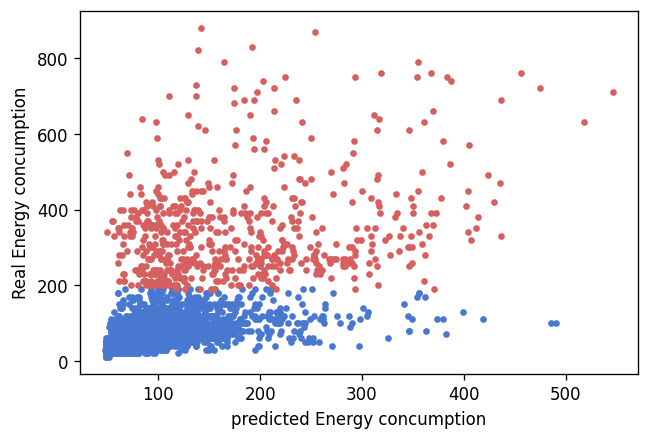

In [68]:
# Scatterplot

f = plt.subplots(dpi = 120)

plt.plot(pred_test , test['Appliances'], '.b', label = 'test')

plt.plot(pred_test_extpl , extpl_test['Appliances'], '.r', label='extrpl')

plt.xlabel('predicted Energy concumption')
plt.ylabel('Real Energy concumption')

**Written answer:** 
As the new model is fitted on the combined training data, its predictions on the standard data gets worst and for the extrapolated data gets better.
The model's performance decreased for the standard data, the MAPE changing from 19% to 47%. Whereas the model's performance for the extrapolated data increased, the MAPE changed from 69% to 47%.
